In [17]:
### Library Imports

import pandas as pd
import numpy as np
import math 
import seaborn as sns 
import matplotlib.pyplot as plt
from datetime import datetime
import yfinance as yf 
import matplotlib.dates as mdates
from tabulate import tabulate

In [20]:
### Load in Stock Data

tickers = ['GOOG', 'AAPL']
start_date = '2021-02-01'

def import_stock_data(tickers, start_date):
    data = pd.DataFrame()
    if len([tickers]) == 1:
        data[tickers] = yf.download(tickers, start_date)['Adj Close']
        data = pd.DataFrame(data)
    else:
        for t in tickers:
            data[t] = yf.download(tickers, start_date)['Adj Close']
    # Reset index to make headings in the same row
    data.reset_index(inplace = True)

    data['Date'] = pd.to_datetime(data['Date'])

    return data

stock_data = import_stock_data(tickers, start_date)
stock_data

[*********************100%%**********************]  2 of 2 completed


,Date,GOOG,AAPL
0,2021-02-01,131.644104,95.067497
1,2021-02-02,132.478302,96.375504
2,2021-02-03,131.447815,103.503502
3,2021-02-04,134.833603,103.118500
4,2021-02-05,134.415878,104.900002
...,...,...,...
771,2024-02-26,181.160004,138.750000
772,2024-02-27,182.630005,140.100006
773,2024-02-28,181.419998,137.429993
774,2024-02-29,180.750000,139.779999


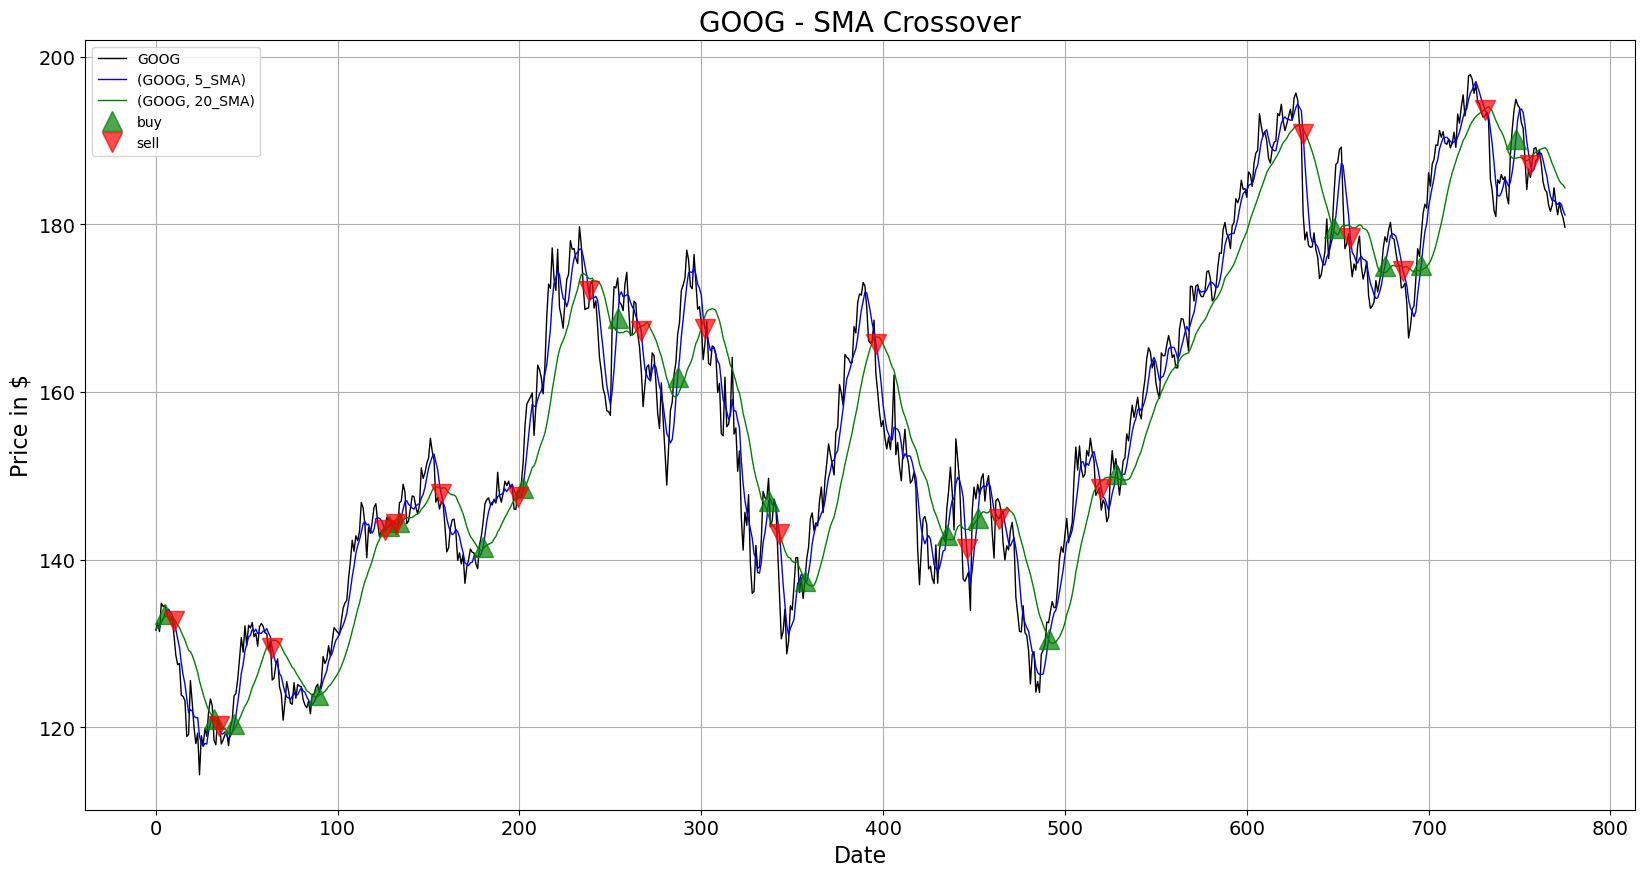

/var/folders/n5/bknqp6qs37l5l4bwv9wv3bs40000gn/T/ipykernel_58534/2794180271.py:62: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_pos[(ticker, 'Position')] = df_pos[(ticker, 'Position')].apply(lambda x: 'Buy' if x == 1 else 'Sell')


+-----+---------------------+---------+---------+---------------------+----------------------+----------------------+----------------------+-----------------------+---------------------+----------------------+----------------------+----------------------+-----------------------+----------------------+------------------------+
|     | Date                |    GOOG |    AAPL |   ('GOOG', '5_SMA') |   ('GOOG', '10_SMA') |   ('GOOG', '20_SMA') |   ('GOOG', '50_SMA') |   ('GOOG', '100_SMA') |   ('AAPL', '5_SMA') |   ('AAPL', '10_SMA') |   ('AAPL', '20_SMA') |   ('AAPL', '50_SMA') |   ('AAPL', '100_SMA') |   ('GOOG', 'Signal') | ('GOOG', 'Position')   |
|-----+---------------------+---------+---------+---------------------+----------------------+----------------------+----------------------+-----------------------+---------------------+----------------------+----------------------+----------------------+-----------------------+----------------------+------------------------|
|   5 | 2021-02-

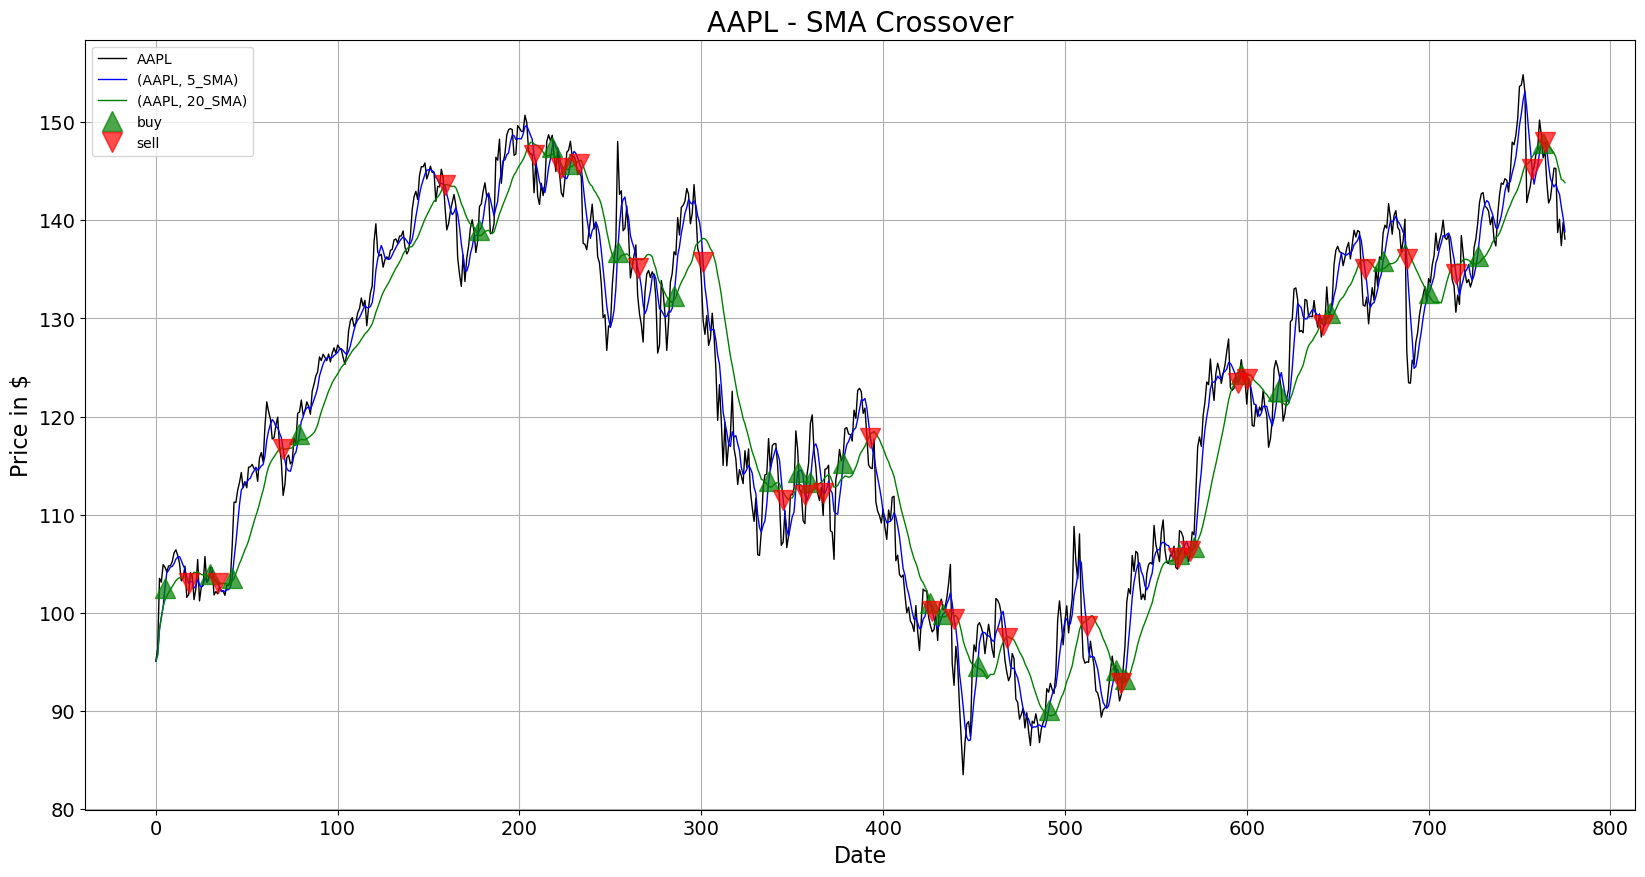

+-----+---------------------+---------+---------+---------------------+----------------------+----------------------+----------------------+-----------------------+---------------------+----------------------+----------------------+----------------------+-----------------------+----------------------+------------------------+----------------------+------------------------+
|     | Date                |    GOOG |    AAPL |   ('GOOG', '5_SMA') |   ('GOOG', '10_SMA') |   ('GOOG', '20_SMA') |   ('GOOG', '50_SMA') |   ('GOOG', '100_SMA') |   ('AAPL', '5_SMA') |   ('AAPL', '10_SMA') |   ('AAPL', '20_SMA') |   ('AAPL', '50_SMA') |   ('AAPL', '100_SMA') |   ('GOOG', 'Signal') |   ('GOOG', 'Position') |   ('AAPL', 'Signal') | ('AAPL', 'Position')   |
|-----+---------------------+---------+---------+---------------------+----------------------+----------------------+----------------------+-----------------------+---------------------+----------------------+----------------------+----------------

/var/folders/n5/bknqp6qs37l5l4bwv9wv3bs40000gn/T/ipykernel_58534/2794180271.py:62: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_pos[(ticker, 'Position')] = df_pos[(ticker, 'Position')].apply(lambda x: 'Buy' if x == 1 else 'Sell')


In [24]:
### Function to display SMA and EMA

def MovingAverageCrossStrategy(stock_data, window, short_window, long_window, moving_avg_type, display_table = True):
    '''
    The function accepts parameters such as the stock symbol, analysis duration, look-back periods, and the type of moving average 
    (SMA or EMA) to generate a Moving Average (MA) Crossover chart. Additionally, it provides buy/sell signals for the specified period.
    Code adopted from: https://towardsdatascience.com/making-a-trade-call-using-simple-moving-average-sma-crossover-strategy-python-implementation-29963326da7a
    '''
    # Parameters:
    # stock_data: (DataFrame) containing dates and closing prices
    # window: (array) specifying the moving average period, e.g., 5, 10, 20...
    # short_window: (int) specifying desired beginning window
    # long_window: (int) specifying desired ending window
    # moving_avg_type: (string) indicating the type of moving average to use ('SMA' or 'EMA')
    # display_table: (boolean) determining whether to display the date and price table at buy/sell positions (True/False)

    # Loop to compute moving averages for each ticker
    for ticker in tickers:
        if moving_avg_type == 'SMA':
            for val in window:
                stock_data[(ticker, f'{val}_SMA')] = stock_data[ticker].rolling(window = val, min_periods = 1).mean()
        elif moving_avg_type == 'EMA':
            for val in window:
                stock_data[(ticker, f'{val}_EMA')] = stock_data[ticker].ewm(span = val, adjust = False).mean()

    # Loop over tickers to create plots and display tables
    for ticker in tickers:
        # Construct column names for short and long moving average columns
        short_window_col = (ticker, f'{short_window}_{moving_avg_type}')
        long_window_col = (ticker, f'{long_window}_{moving_avg_type}')

        # Create a new column 'Signal' based on crossover strategy
        stock_data[(ticker, 'Signal')] = np.where(stock_data[short_window_col] > stock_data[long_window_col], 1.0, 0.0)
        stock_data[(ticker, 'Position')] = stock_data[(ticker, 'Signal')].diff()

        # Plot closing prices and moving averages for the current ticker
        plt.figure(figsize=(20, 10))
        plt.tick_params(axis = 'both', labelsize = 14)
        stock_data[ticker].plot(color = 'k', lw = 1, label=ticker)
        stock_data[short_window_col].plot(color = 'b', lw = 1, label=short_window_col)
        stock_data[long_window_col].plot(color = 'g', lw = 1, label=long_window_col)

        # Plot buy signals
        plt.plot(stock_data[stock_data[(ticker, 'Position')] == 1].index,
                 stock_data[short_window_col][stock_data[(ticker, 'Position')] == 1],
                 '^', markersize = 15, color = 'g', alpha = 0.7, label = 'buy')

        # Plot sell signals
        plt.plot(stock_data[stock_data[(ticker, 'Position')] == -1].index,
                 stock_data[short_window_col][stock_data[(ticker, 'Position')] == -1],
                 'v', markersize = 15, color = 'r', alpha = 0.7, label = 'sell')
        plt.ylabel('Price in $', fontsize = 16)
        plt.xlabel('Date', fontsize = 16)
        plt.title(f'{ticker} - {moving_avg_type} Crossover', fontsize = 20)
        plt.legend()
        plt.grid()
        plt.show()

        if display_table:
            # Display buy/sell signals table
            df_pos = stock_data[((stock_data[(ticker, 'Position')] == 1) | (stock_data[(ticker, 'Position')] == -1))]
            df_pos[(ticker, 'Position')] = df_pos[(ticker, 'Position')].apply(lambda x: 'Buy' if x == 1 else 'Sell')
            print(tabulate(df_pos, headers = 'keys', tablefmt = 'psql'))

### Function call
window = [5, 10, 20, 50, 100]
short_window = 5
long_window = 20
MovingAverageCrossStrategy(stock_data, window, short_window, long_window, moving_avg_type = 'SMA', display_table = True)